<a href="https://www.kaggle.com/code/charmainechiam/prediction-of-stroke?scriptVersionId=139052775" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Stroke Prediction Machine Learning Project
The aim of this project is to **predict whether or not an individual will suffer a stroke.**

First, we will navigate through and dive into the data using data visualizations. This will help us to see if there are any features that highly affect the outcome of stroke.

Next, we will build a few models and select the best performing model. F1 score will be used as the primary metric as the dataset used is imbalanced. SMOTE will also be used to resolve this data imbalance.

# 1. Importing Data and libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.gridspec as grid_spec
import seaborn as sns
from imblearn.over_sampling import SMOTE
import scikitplot as skplt


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score


from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, precision_score, f1_score
import warnings
warnings.filterwarnings('ignore')
!pip install pywaffle

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 62.8 MB/s eta 0:00:00


In [2]:
df = pd.read_csv("/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv")
df.head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# 2. Data Pre-Processing

In [3]:
#check for missing data
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

There are 201 missing data from the attribute 'bmi'. 

**Dealing with blanks**
There are a few ways:
1. Dropping the records
2. Fill the blanks with mean, median
3. Record before or after the missing value

Here, we will use **Decision Tree to predict the missing BMI**

Other methods that can be explored is K-Nearest Neightbours. 

In [4]:
# A really fantsatic and intelligent way to deal with blanks, from Thoman Konstantin in: https://www.kaggle.com/thomaskonstantin/analyzing-and-modeling-stroke-data

DT_bmi_pipe = Pipeline( steps=[ 
                               ('scale',StandardScaler()),
                               ('lr',DecisionTreeRegressor(random_state=42))
                              ])

#Creating X variable with 3 attributes
X = df[['age','gender','bmi']].copy()
#replacing the categorical values with numerical values
X.gender = X.gender.replace({'Male':0,'Female':1,'Other':-1}).astype(np.uint8)

Missing = X[X.bmi.isna()]
X = X[~X.bmi.isna()] #~ means NOT, return results that is not missing BMI
Y = X.pop('bmi') #extracting the bmi data from X

#Train data
DT_bmi_pipe.fit(X,Y)

predicted_bmi = pd.Series(DT_bmi_pipe.predict(Missing[['age','gender']]),index=Missing.index)

#Replacing the missing data with the predicted values
df.loc[Missing.index,'bmi'] = predicted_bmi

***Explanation:***
First we create a copy of our df with 3 columns, 'age', 'gender' and 'bmi'. Then we replace the categorical values with numerical values.

We then filter all missing data into a variable. Get age and gender that are not missing BMI as training data, and separating the BMI as Y as the expected output. Then we train the model and the predict it using the attributes age and gender that are missing BMI to get the predicted values.

DataFrame.loc attribute access a group of rows and columns by label(s) or a boolean array in the given Pandas DataFrame. By accessing the missing indexes, we replace the null value to the predicted values.

As a result, the missing values are now zero.

In [5]:
print('Missing values: ',sum(df.isnull().sum()))

Missing values:  0


# 3. Exploring the data

Let's dive into finding relationships between attributes with the target outcome. Eg. Does age makes one more likely to suffer stroke? or gender or bmi?

Frist, Let's look at the numerical/continuous variable distribution

In [6]:
var = [var for var in df.columns if var not in ['id', 'stroke']]

conts = ['age', 'avg_glucose_level', 'bmi']

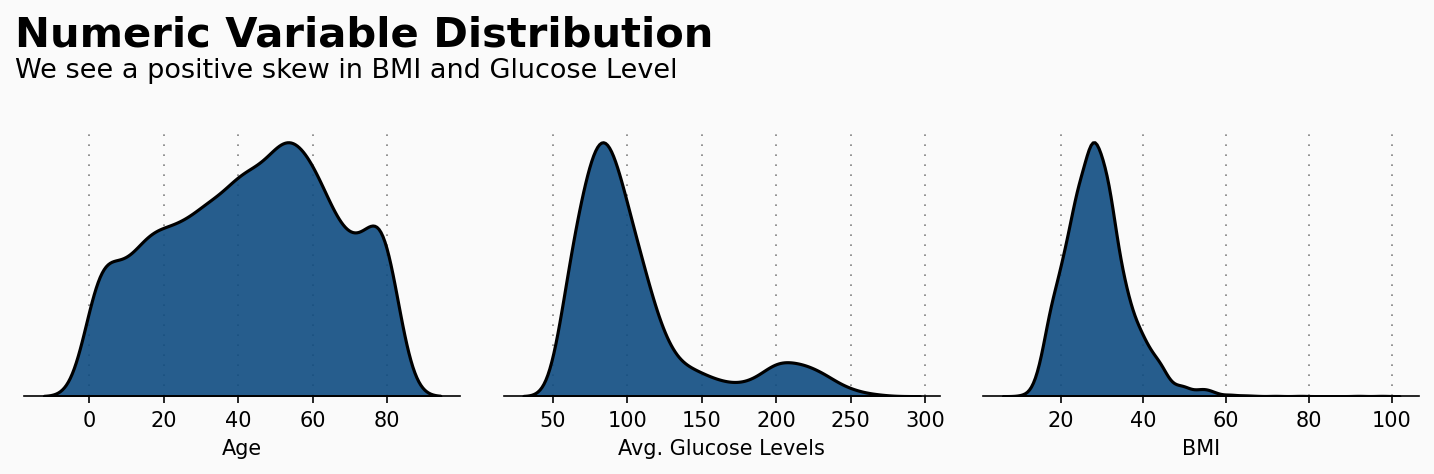

In [7]:
fig = plt.figure(figsize=(12, 12), dpi=150, facecolor='#fafafa') #plot background color, light grey
gs = fig.add_gridspec(4, 3)
gs.update(wspace=0.1, hspace=0.4)

background_color = "#fafafa"

plot = 0
for row in range(0, 1): ##this line not really neccesary imo
    for col in range(0, 3): #3 graphs so to loop 3 times
        locals()["ax"+str(plot)] = fig.add_subplot(gs[row, col]) #locals allow loop through ax1, ax2, ax3
        locals()["ax"+str(plot)].set_facecolor(background_color)
        locals()["ax"+str(plot)].tick_params(axis='y', left=False)
        locals()["ax"+str(plot)].get_yaxis().set_visible(False)
        #removing the top, left, right borders of the figure aka SPINE
        for s in ["top","right","left"]:
            locals()["ax"+str(plot)].spines[s].set_visible(False)
        plot += 1

plot = 0
for variable in conts:
        sns.kdeplot(df[variable] ,ax=locals()["ax"+str(plot)], color='#0f4c81', shade=True, linewidth=1.5, ec='black',alpha=0.9, zorder=3, legend=False)
        locals()["ax"+str(plot)].grid(which='major', axis='x', zorder=0, color='gray', linestyle=':', dashes=(1,5))
        #locals()["ax"+str(plot)].set_xlabel(variable) #removed this for aesthetics
        plot += 1
        
ax0.set_xlabel('Age') #when plot = 0
ax1.set_xlabel('Avg. Glucose Levels') #when plot = 1
ax2.set_xlabel('BMI') # when plot = 2


ax0.text(-20, 0.022, 'Numeric Variable Distribution', fontsize=20, fontweight='bold', fontfamily='Verdana')
ax0.text(-20, 0.02, 'We see a positive skew in BMI and Glucose Level', fontsize=13, fontweight='light', fontfamily='Verdana')

plt.show()

**Documentation on using ax.spine** -> https://towardsdatascience.com/handling-plot-axis-spines-in-python-f143b8554da2

Now that we have the distribution of our numeric variables. Let's see how it differes comparing those that have strokes and those that do not.

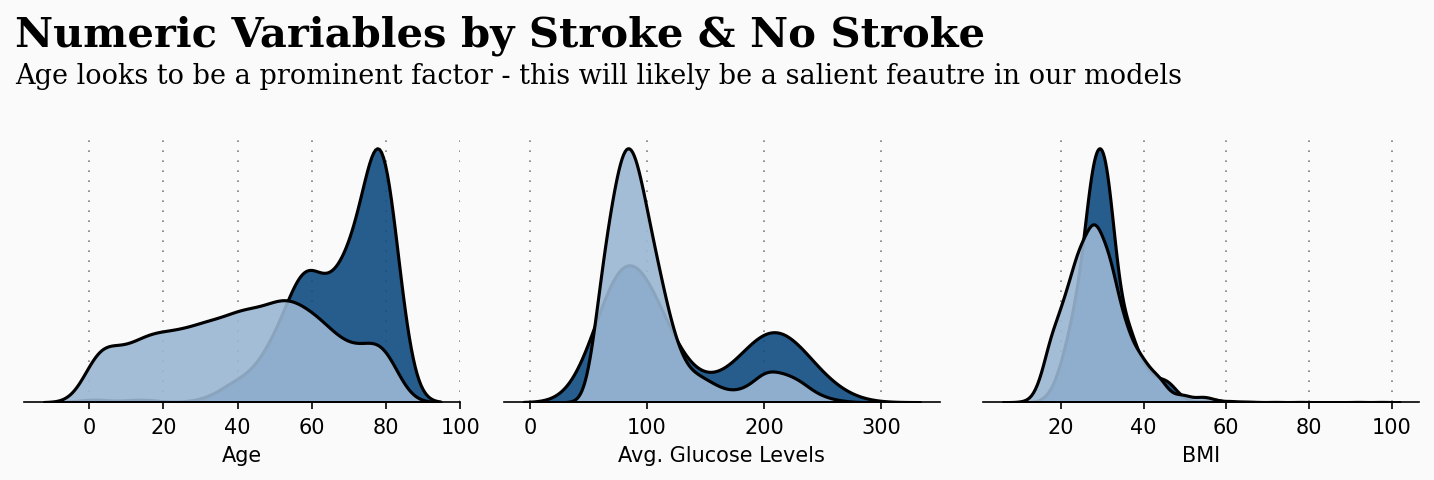

In [8]:
fig = plt.figure(figsize=(12, 12), dpi=150,facecolor=background_color)
gs = fig.add_gridspec(4, 3)
gs.update(wspace=0.1, hspace=0.4)


plot = 0
for row in range(0, 1):
    for col in range(0, 3):
        locals()["ax"+str(plot)] = fig.add_subplot(gs[row, col])
        locals()["ax"+str(plot)].set_facecolor(background_color)
        locals()["ax"+str(plot)].tick_params(axis='y', left=False)
        locals()["ax"+str(plot)].get_yaxis().set_visible(False)
        for s in ["top","right","left"]:
            locals()["ax"+str(plot)].spines[s].set_visible(False)
        plot += 1

plot = 0

s = df[df['stroke'] == 1] #filter to stroke
ns = df[df['stroke'] == 0] #filter to no stroke

for feature in conts:
        sns.kdeplot(s[feature], ax=locals()["ax"+str(plot)], color='#0f4c81', shade=True, linewidth=1.5, ec='black',alpha=0.9, zorder=3, legend=False)
        sns.kdeplot(ns[feature],ax=locals()["ax"+str(plot)], color='#9bb7d4', shade=True, linewidth=1.5, ec='black',alpha=0.9, zorder=3, legend=False)
        locals()["ax"+str(plot)].grid(which='major', axis='x', zorder=0, color='gray', linestyle=':', dashes=(1,5))
        #locals()["ax"+str(plot)].set_xlabel(feature)
        plot += 1

ax0.set_xlabel('Age')
ax1.set_xlabel('Avg. Glucose Levels')
ax2.set_xlabel('BMI')
        
ax0.text(-20, 0.056, 'Numeric Variables by Stroke & No Stroke', fontsize=20, fontweight='bold', fontfamily='serif')
ax0.text(-20, 0.05, 'Age looks to be a prominent factor - this will likely be a salient feautre in our models', 
         fontsize=13, fontweight='light', fontfamily='serif')

plt.show()

# 4. Insights
It seems clear that age is a big factor in stroke patients, which means the older you get the more at risk you are of getting a stroke.

Let's explore avg gluose levels and BMI variables further...

In [9]:
str_only = df[df['stroke'] == 1]
no_str_only = df[df['stroke'] == 0]

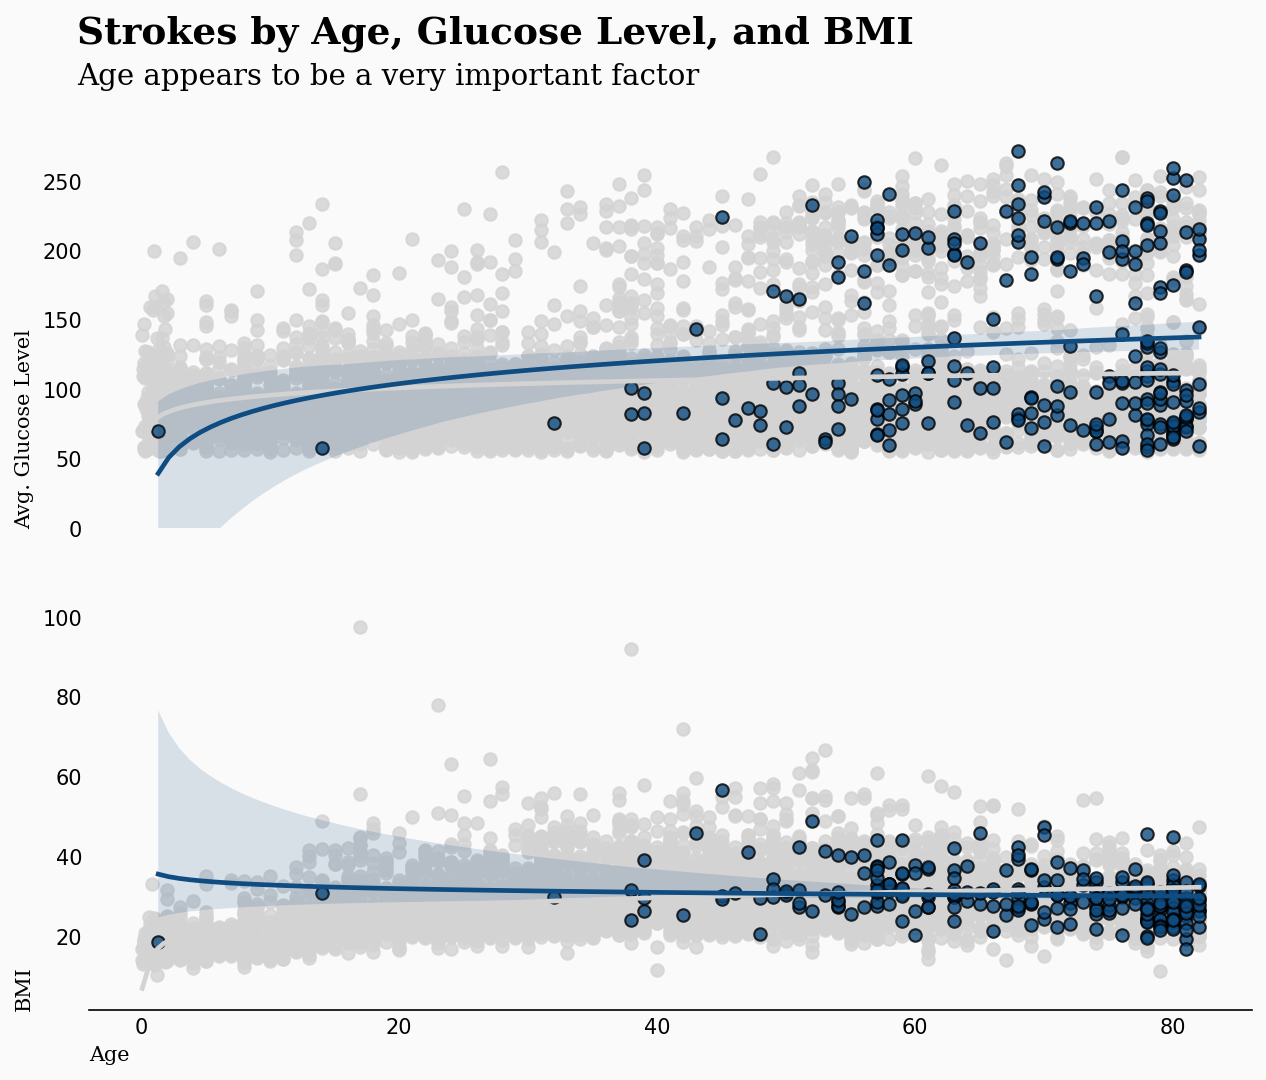

In [10]:
fig = plt.figure(figsize=(10,16),dpi=150,facecolor=background_color) 
gs = fig.add_gridspec(4, 2)
gs.update(wspace=0.5, hspace=0.2)
ax0 = fig.add_subplot(gs[0, 0:2])
ax1 = fig.add_subplot(gs[1, 0:2]) 

ax0.set_facecolor(background_color)
ax1.set_facecolor(background_color)

# glucose
#no stroke data = lightgray
#stroke data = blue

sns.regplot(x=no_str_only['age'],y=no_str_only['avg_glucose_level'],  
            color='lightgray',
            logx=True,
            ax=ax0)

sns.regplot(x=str_only['age'],y=str_only['avg_glucose_level'],  
            color='#0f4c81',
            logx=True,scatter_kws={'edgecolors':['black'], 
                                              'linewidth': 1},
            ax=ax0)

#glucose plot customization
ax0.set(ylim=(0, None)) #set y axis start from 0
ax0.set_xlabel(" ",fontsize=12,fontfamily='serif')
ax0.set_ylabel("Avg. Glucose Level",fontsize=10,fontfamily='serif',loc='bottom')

ax0.tick_params(axis='x', bottom=False)
ax0.get_xaxis().set_visible(False) #x-axis set as FALSE to appear as shared axis with the bottom plot

for s in ['top','left','bottom']:
    ax0.spines[s].set_visible(False)
    
# bmi
sns.regplot(x=no_str_only['age'],y=no_str_only['bmi'],  
            color='lightgray',
            logx=True,
            ax=ax1)

sns.regplot(x=str_only['age'],y=str_only['bmi'],  
            color='#0f4c81', scatter_kws={'edgecolors':['black'], 
                                              'linewidth': 1},
            logx=True,
            ax=ax1)

#bmi plot customization
ax1.set_xlabel("Age",fontsize=10,fontfamily='serif',loc='left')
ax1.set_ylabel("BMI",fontsize=10,fontfamily='serif',loc='bottom')

#removing the outside borders for plot except for bottom x-axis
for s in ['top','left','right']:
    ax0.spines[s].set_visible(False)
    ax1.spines[s].set_visible(False)

    
ax0.text(-5,350,'Strokes by Age, Glucose Level, and BMI',fontsize=18,fontfamily='serif',fontweight='bold')
ax0.text(-5,320,'Age appears to be a very important factor',fontsize=14,fontfamily='serif')


ax0.tick_params(axis=u'both', which=u'both',length=0)
ax1.tick_params(axis=u'both', which=u'both',length=0)

plt.show()


The regression plots above shows that age has slight relationships with BMI and AVG Glucose levels. We can make that deduction because we can see that the scatter dots for both grey and blue (non-stroke and stroke) aggregates more closely as age increases. Although for BMI, the grey (non-stoke) dots seems to be quite equal throughout all ages, but the blue dots that aggregate towards the end shows some correlations with age.

Now that we understand that as age increases, the risk of stroke increases too. Let's re-visualize this. 

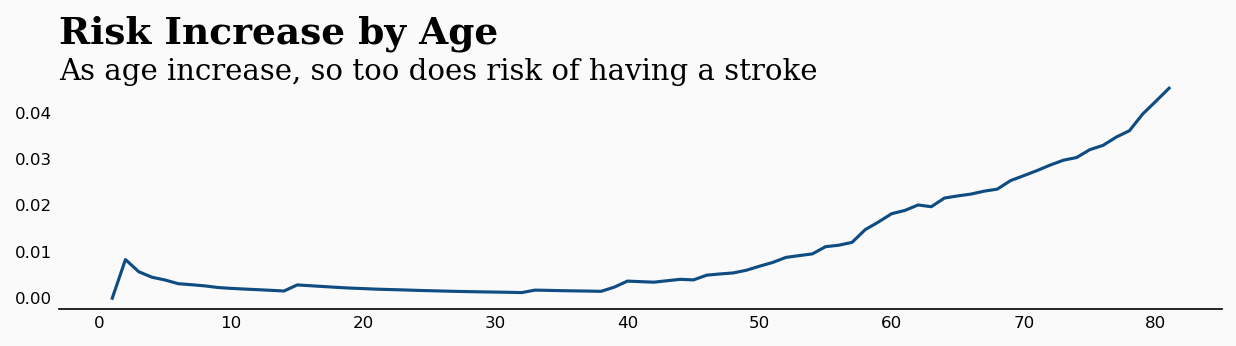

In [11]:
fig = plt.figure(figsize=(10,5), dpi=150, facecolor=background_color)
gs = fig.add_gridspec(2,1) #creating the grid space for plot
gs.update(wspace=0.11, hspace=0.5)
ax0 = fig.add_subplot(gs[0,0]) #first plot gridspce position
ax0.set_facecolor(background_color)

df['age'] = df['age'].astype(int)

rate = []
for i in range(df['age'].min(), df['age'].max()):
    rate.append(df[df['age']<i]['stroke'].sum() / len(df[df['age']<i]['stroke']))
    '''appending rate list while calculating the rates by 
    diving the sum of people within the age group and dividing by the number of people of that age
    '''
                
sns.lineplot(data=rate, color='#0f4c81', ax=ax0)

for s in ["top","right","left"]:
    ax0.spines[s].set_visible(False)


ax0.tick_params(axis='both', which='major', labelsize=8)
ax0.tick_params(axis=u'both', which=u'both', length=0)
                
ax0.text(-3,0.055,'Risk Increase by Age',fontsize=18,fontfamily='serif',fontweight='bold')
ax0.text(-3,0.047,'As age increase, so too does risk of having a stroke',fontsize=14,fontfamily='serif')

                
plt.show()

However, you may notice the low risk values on the y-axis of only up to 0.04, this is because the dataset is **highly imbalanced**. There are only 249 strokes in our dataset with a total of 5000 samples, which is only 1 in 20. 

**We have have a closer look at the dataframe by using info() and value_counts(). This should have probably be done at the beginning during data Pre-Processing but it is normal that we may jump back and forth certain steps as we get deeper insights on the data with visualizations.**

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   int64  
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                5110 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 479.2+ KB


In [13]:
df['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

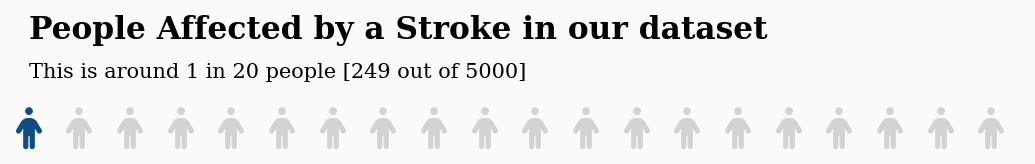

In [14]:
from pywaffle import Waffle

fig = plt.figure(figsize=(7, 2),dpi=150,facecolor=background_color,
    FigureClass=Waffle,
    rows=1,
    values=[1, 19],
    colors=['#0f4c81', "lightgray"],
    icons='person',
    font_size=20,vertical=True,
)

fig.text(0.035,0.78,'People Affected by a Stroke in our dataset',fontfamily='serif',fontsize=15,fontweight='bold')
fig.text(0.035,0.65,'This is around 1 in 20 people [249 out of 5000]',fontfamily='serif',fontsize=10)

plt.show()

This imbalanced needs to be considered when training a model and also formulating risk. 

Although stroke is relatively rare and we do not know the scientifically proven rates or prevalence of strokes. We can only confirm that the risk increases with age from the data.

In [15]:
#dropping one row that has other as gender
no_str_only = no_str_only[(no_str_only['gender'] != 'Other')]

In [16]:
#To view which row it is
df[df['gender']=='Other']

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3116,56156,Other,26,0,0,No,Private,Rural,143.33,22.4,formerly smoked,0


# 5. General Overview
We have assesed a few variables and gained insights. 
We will now plot several variables in one place so we can spot interesting trends or features by splitting the data to 'stroke' and 'no stroke' so that we can see how they differ in a meaningful way

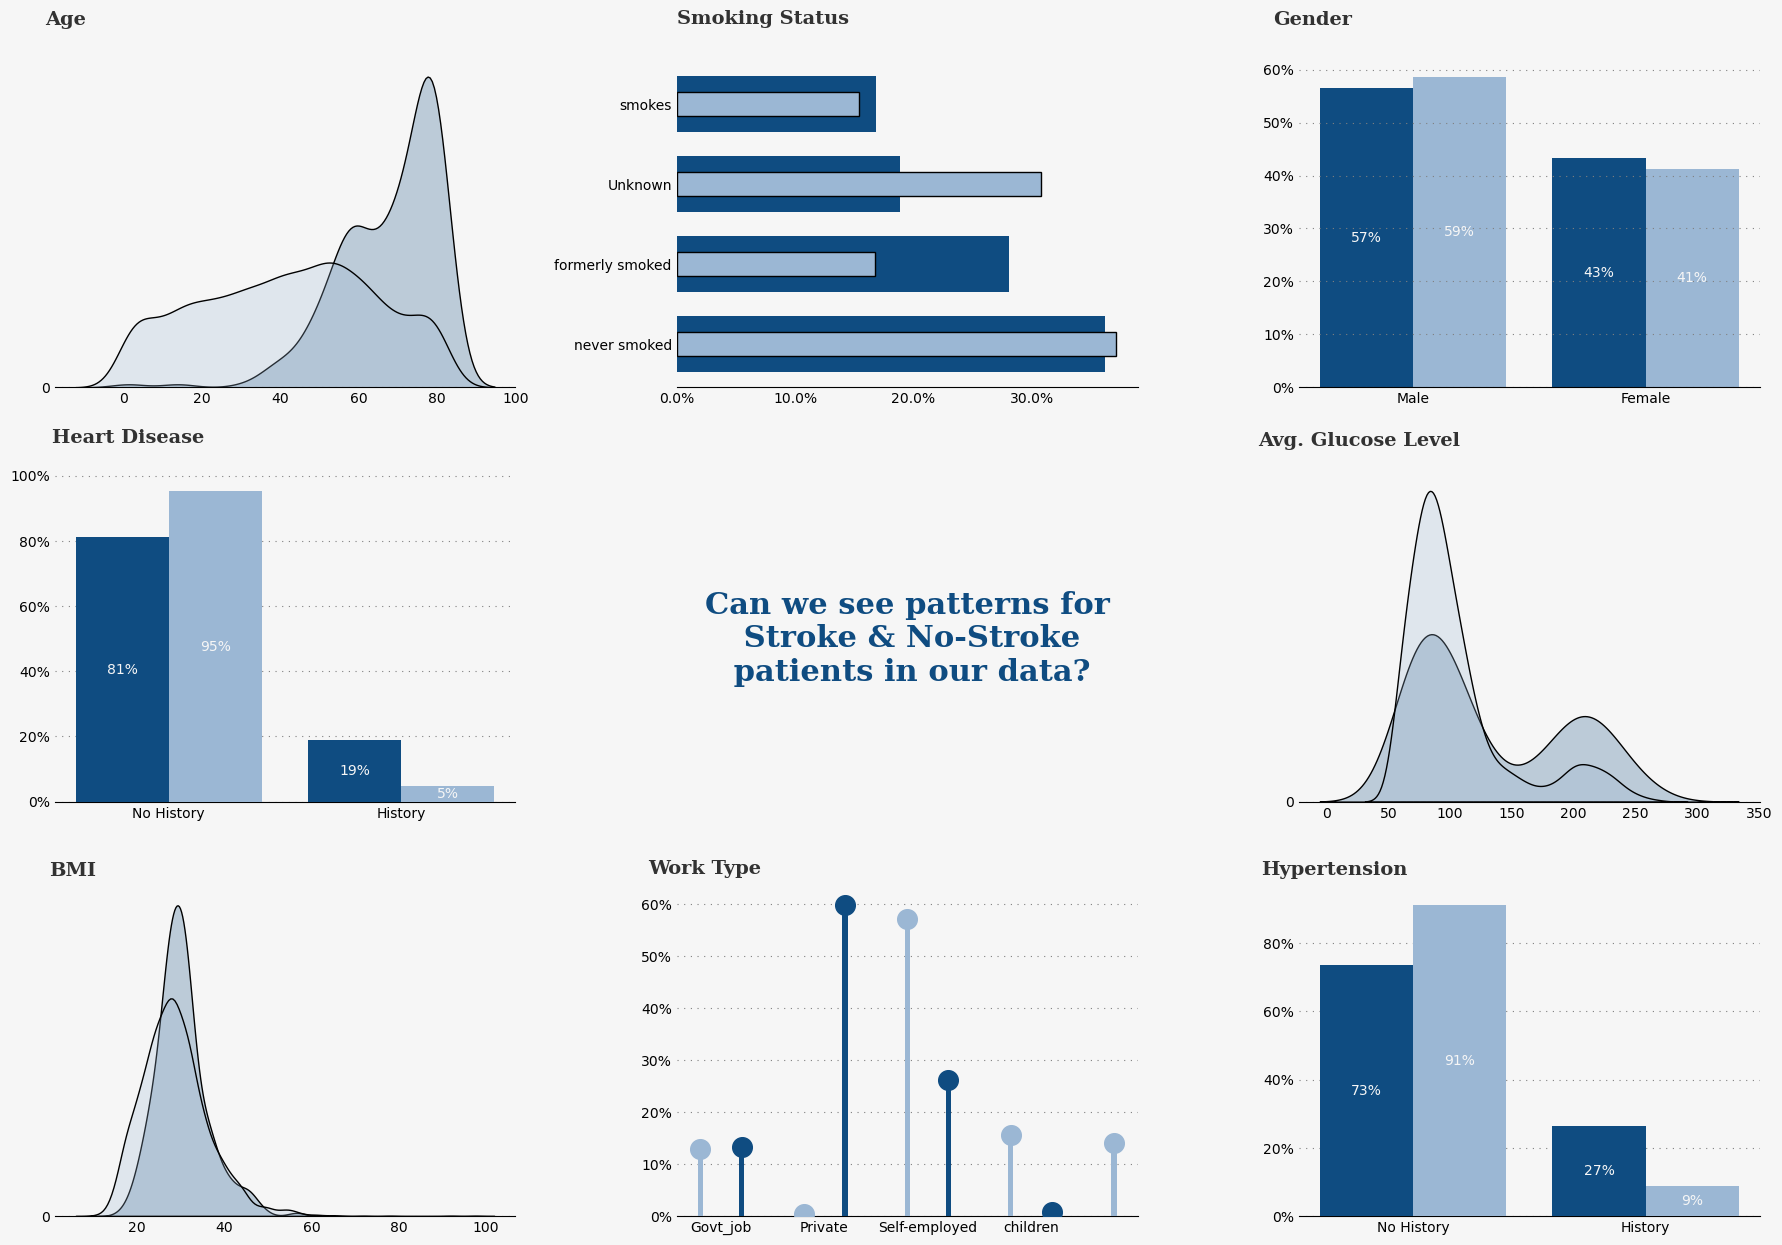

In [17]:
#plot area settings
fig = plt.figure(figsize=(22,15))
gs = fig.add_gridspec(3, 3)
gs.update(wspace=0.35, hspace=0.27)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[1, 2])
ax6 = fig.add_subplot(gs[2, 0])
ax7 = fig.add_subplot(gs[2, 1])
ax8 = fig.add_subplot(gs[2, 2])

background_color = "#f6f6f6"
fig.patch.set_facecolor(background_color) # figure background color

#Plots

##Age
ax0.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))

positive = pd.DataFrame(str_only["age"])
negative = pd.DataFrame(no_str_only["age"])

sns.kdeplot(positive["age"], ax=ax0,color="#0f4c81", shade=True, ec='black',label="positive")
sns.kdeplot(negative["age"], ax=ax0, color="#9bb7d4", shade=True, ec='black',label="negative")

#ax3.text(0.29, 13, 'Age', 
 #        fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")

ax0.yaxis.set_major_locator(mtick.MultipleLocator(2))
ax0.set_ylabel('')    
ax0.set_xlabel('')
ax0.text(-20, 0.0465, 'Age', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")



##Smoking
positive = pd.DataFrame(str_only["smoking_status"].value_counts())
positive["Percentage"] = positive["smoking_status"].apply(lambda x: x/sum(positive["smoking_status"])*100)
negative = pd.DataFrame(no_str_only["smoking_status"].value_counts())
negative["Percentage"] = negative["smoking_status"].apply(lambda x: x/sum(negative["smoking_status"])*100)

ax1.text(0, 4, 'Smoking Status', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax1.barh(positive.index, positive['Percentage'], color="#0f4c81", zorder=3, height=0.7) #dark
ax1.barh(negative.index, negative['Percentage'], color="#9bb7d4", zorder=3,ec='black', height=0.3) #light
ax1.xaxis.set_major_formatter(mtick.PercentFormatter())
ax1.xaxis.set_major_locator(mtick.MultipleLocator(10))

##Gender
positive = pd.DataFrame(str_only["gender"].value_counts())
positive["Percentage"] = positive["gender"].apply(lambda x: x/sum(positive["gender"])*100)
negative = pd.DataFrame(no_str_only["gender"].value_counts())
negative["Percentage"] = negative["gender"].apply(lambda x: x/sum(negative["gender"])*100)

x = np.arange(len(positive)) # np.arange -> Return evenly spaced values within a given interval

ax2.text(-0.4, 68.5, 'Gender', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax2.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
ax2.bar(x, height=positive["Percentage"], color="#0f4c81", width=0.4) #dark
#set as x+0.4 because position is right beside the width of dark bar chart, which is 0.4 as line above
ax2.bar(x+0.4, height=negative["Percentage"], color="#9bb7d4", width=0.4) #light
ax2.set_xticks(x + 0.4 / 2)
ax2.set_xticklabels(['Male','Female'])
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
ax2.yaxis.set_major_locator(mtick.MultipleLocator(10)) #interval between percentages

for i,j in zip([0, 1], positive["Percentage"]):
    ax2.annotate(f'{j:0.0f}%',xy=(i, j/2), color='#f6f6f6', horizontalalignment='center', verticalalignment='center')
for i,j in zip([0, 1], negative["Percentage"]):
    ax2.annotate(f'{j:0.0f}%',xy=(i+0.4, j/2), color='#f6f6f6', horizontalalignment='center', verticalalignment='center')
    
##Heart Disease history
positive = pd.DataFrame(str_only["heart_disease"].value_counts())
positive["Percentage"] = positive["heart_disease"].apply(lambda x: x/sum(positive["heart_disease"])*100)
negative = pd.DataFrame(no_str_only["heart_disease"].value_counts())
negative["Percentage"] = negative["heart_disease"].apply(lambda x: x/sum(negative["heart_disease"])*100)

x = np.arange(len(positive))

ax3.text(-0.3, 110, 'Heart Disease', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax3.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
ax3.bar(x, height=positive["Percentage"], zorder=3, color="#0f4c81", width=0.4)
ax3.bar(x+0.4, height=negative["Percentage"], zorder=3, color="#9bb7d4", width=0.4)
ax3.set_xticks(x + 0.4 / 2)
ax3.set_xticklabels(['No History','History'])
ax3.yaxis.set_major_formatter(mtick.PercentFormatter())
ax3.yaxis.set_major_locator(mtick.MultipleLocator(20))

#How to display values inside bar charts
for i,j in zip([0, 1], positive["Percentage"]): #get the percentage for index 0 and index 1: Female and Male in all positive percentage
    ax3.annotate(f'{j:0.0f}%',xy=(i, j/2), color='#f6f6f6', horizontalalignment='center', verticalalignment='center')
for i,j in zip([0, 1], negative["Percentage"]): #get the percentage for index 0 and index 1: Female and Male in all negative percentage
    ax3.annotate(f'{j:0.0f}%',xy=(i+0.4, j/2), color='#f6f6f6', horizontalalignment='center', verticalalignment='center')

## AX4 - TITLE of GRAPHS

ax4.spines["bottom"].set_visible(False)
ax4.tick_params(left=False, bottom=False)
ax4.set_xticklabels([])
ax4.set_yticklabels([])
ax4.text(0.5, 0.5, 'Can we see patterns for\n Stroke & No-Stroke\n patients in our data?', horizontalalignment='center', verticalalignment='center',
         fontsize=22, fontweight='bold', fontfamily='serif', color="#0f4c81")

#This is more specific position if you want stroke and no-stroke to be different font colors. Good to keep for future reference purposes. 
'''ax4.text(0.15,0.57,"Stroke", fontweight="bold", fontfamily='serif', fontsize=22, color='#0f4c81')
ax4.text(0.41,0.57,"&", fontweight="bold", fontfamily='serif', fontsize=22, color='#323232')
ax4.text(0.49,0.57,"No-Stroke", fontweight="bold", fontfamily='serif', fontsize=22, color='#9bb7d4')
'''

##Glucose

ax5.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
positive = pd.DataFrame(str_only["avg_glucose_level"])
negative = pd.DataFrame(no_str_only["avg_glucose_level"])
sns.kdeplot(positive["avg_glucose_level"], ax=ax5, color="#0f4c81",ec='black', shade=True, label="positive")
sns.kdeplot(negative["avg_glucose_level"], ax=ax5, color="#9bb7d4", ec='black',shade=True, label="negative")
ax5.text(-55, 0.01855, 'Avg. Glucose Level', 
         fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax5.yaxis.set_major_locator(mtick.MultipleLocator(2))
ax5.set_ylabel('')    
ax5.set_xlabel('')

## BMI


ax6.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
positive = pd.DataFrame(str_only["bmi"])
negative = pd.DataFrame(no_str_only["bmi"])
sns.kdeplot(positive["bmi"], ax=ax6,color="#0f4c81", ec='black',shade=True, label="positive")
sns.kdeplot(negative["bmi"], ax=ax6, color="#9bb7d4",ec='black', shade=True, label="negative")
ax6.text(-0.06, 0.09, 'BMI', 
         fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax6.yaxis.set_major_locator(mtick.MultipleLocator(2))
ax6.set_ylabel('')    
ax6.set_xlabel('')

# Work Type

positive = pd.DataFrame(str_only["work_type"].value_counts())
positive["Percentage"] = positive["work_type"].apply(lambda x: x/sum(positive["work_type"])*100)
positive = positive.sort_index()

negative = pd.DataFrame(no_str_only["work_type"].value_counts())
negative["Percentage"] = negative["work_type"].apply(lambda x: x/sum(negative["work_type"])*100)
negative = negative.sort_index()

#combination of scatter plot and bar chart 
ax7.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
ax7.bar(negative.index, height=negative["Percentage"], zorder=3, color="#9bb7d4", width=0.05)
ax7.scatter(negative.index, negative["Percentage"], zorder=3,s=200, color="#9bb7d4")
ax7.bar(np.arange(len(positive.index))+0.4, height=positive["Percentage"], zorder=3, color="#0f4c81", width=0.05)
ax7.scatter(np.arange(len(positive.index))+0.4, positive["Percentage"], zorder=3,s=200, color="#0f4c81")

ax7.yaxis.set_major_formatter(mtick.PercentFormatter())
ax7.yaxis.set_major_locator(mtick.MultipleLocator(10))
ax7.set_xticks(np.arange(len(positive.index))+0.4 / 2)
ax7.set_xticklabels(list(positive.index),rotation=0)
ax7.text(-0.5, 66, 'Work Type', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")

# hypertension

positive = pd.DataFrame(str_only["hypertension"].value_counts())
positive["Percentage"] = positive["hypertension"].apply(lambda x: x/sum(positive["hypertension"])*100)
negative = pd.DataFrame(no_str_only["hypertension"].value_counts())
negative["Percentage"] = negative["hypertension"].apply(lambda x: x/sum(negative["hypertension"])*100)

x = np.arange(len(positive))
ax8.text(-0.45, 100, 'Hypertension', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax8.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
ax8.bar(x, height=positive["Percentage"], zorder=3, color="#0f4c81", width=0.4)
ax8.bar(x+0.4, height=negative["Percentage"], zorder=3, color="#9bb7d4", width=0.4)
ax8.set_xticks(x + 0.4 / 2)
ax8.set_xticklabels(['No History','History'])
ax8.yaxis.set_major_formatter(mtick.PercentFormatter())
ax8.yaxis.set_major_locator(mtick.MultipleLocator(20))
for i,j in zip([0, 1], positive["Percentage"]):
    ax8.annotate(f'{j:0.0f}%',xy=(i, j/2), color='#f6f6f6', horizontalalignment='center', verticalalignment='center')
for i,j in zip([0, 1], negative["Percentage"]):
    ax8.annotate(f'{j:0.0f}%',xy=(i+0.4, j/2), color='#f6f6f6', horizontalalignment='center', verticalalignment='center')
    
# tidy up



for s in ["top","right","left"]:
    for i in range(0,9):
        locals()["ax"+str(i)].spines[s].set_visible(False)
        
for i in range(0,9):
        locals()["ax"+str(i)].set_facecolor(background_color)
        locals()["ax"+str(i)].tick_params(axis=u'both', which=u'both',length=0)
        locals()["ax"+str(i)].set_facecolor(background_color) 

plt.show()


# 6. Model preparation

To predict whether or not an individual will suffer stroke?

Because our data is imbalanced, we will use **SMOTE(Synthetic Minority Over-sampling Technique)** to balance our dataset. There are more negative examples of stroke that could hinder our model, and this can be addressed using SMOTE.


## Base line
For such an imbalanced dataset, a useful baseline can be to beat the 'Null Accuracy', and in our case, since we're looking for the positive ('stroke'), I will take the inverse of that. In other words, always predicting the most common outcome.Null accuracy, i.e. accuracy when predicting the most frequent class in the training set tells you about the performance of the most trivial (yet, reasonable) model you can have. If your model is worse than that, it means it is very bad.

For this case, 249/(249+4861) = 0.048

So a good target to beat would be 5% ~ for recall for positive stroke patient



In [18]:
# Encoding categorical values

df['gender'] = df['gender'].replace({'Male':0,'Female':1,'Other':-1}).astype(np.uint8)
df['Residence_type'] = df['Residence_type'].replace({'Rural':0,'Urban':1}).astype(np.uint8)
df['work_type'] = df['work_type'].replace({'Private':0,'Self-employed':1,'Govt_job':2,'children':-1,'Never_worked':-2}).astype(np.uint8)

In [19]:
# Inverse of Null Accuracy
print('Inverse of Null Accuracy: ',249/(249+4861))
print('Null Accuracy: ',4861/(4861+249))

Inverse of Null Accuracy:  0.0487279843444227
Null Accuracy:  0.9512720156555773


In [20]:
#get parameters that has relationship to target, anything else is noise to the model
X  = df[['gender','age','hypertension','heart_disease','work_type','avg_glucose_level','bmi']]
y = df['stroke']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.3, random_state=42)

In [21]:
print("Number of samples in X_train dataset: ", X_train.shape)
print("Number of samples in y_train dataset: ", y_train.shape)
print("Number of samples in X_test dataset: ", X_test.shape)
print("Number of samples in y_test dataset: ", y_test.shape)

Number of samples in X_train dataset:  (1533, 7)
Number of samples in y_train dataset:  (1533,)
Number of samples in X_test dataset:  (3577, 7)
Number of samples in y_test dataset:  (3577,)


In [22]:
X_test.head(10)

,gender,age,hypertension,heart_disease,work_type,avg_glucose_level,bmi
4688,0,31,0,0,1,64.85,23.000000
4478,0,40,0,0,1,65.29,28.300000
3849,1,8,0,0,255,74.42,22.500000
4355,1,79,1,0,1,76.64,19.500000
3826,1,75,0,0,2,94.77,27.200000
3951,1,79,1,0,1,92.43,27.934545
3396,1,56,1,0,0,97.37,34.100000
465,0,69,0,0,0,101.52,26.800000
410,0,7,0,0,1,64.06,18.900000
1632,1,1,0,0,255,55.51,18.500000


In [23]:
#Our data is biased, we can fix this with SMOTE

oversample = SMOTE()
X_train_resh, y_train_resh = oversample.fit_resample(X_train, y_train.ravel())

In [24]:
print('Before OverSampling, the shape of train_X: {}'.format(X_train.shape))
print('Before OverSampling, the shape of train_y: {} \n'.format(y_train.shape))


print('After OverSampling, the shape of train_X: {}'.format(X_train_resh.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_resh.shape))

print("Before OverSampling, counts of label '1' stroke: {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0' no-stroke: {} \n".format(sum(y_train == 0)))

print("After OverSampling, counts of label '1' stroke: {}".format(sum(y_train_resh == 1)))
print("After OverSampling, counts of label '0' no-stroke: {}".format(sum(y_train_resh == 0)))

Before OverSampling, the shape of train_X: (1533, 7)
Before OverSampling, the shape of train_y: (1533,) 

After OverSampling, the shape of train_X: (2914, 7)
After OverSampling, the shape of train_y: (2914,) 

Before OverSampling, counts of label '1' stroke: 76
Before OverSampling, counts of label '0' no-stroke: 1457 

After OverSampling, counts of label '1' stroke: 1457
After OverSampling, counts of label '0' no-stroke: 1457


Now, our data is equal.

# 7. Models
We will use:
1. Random Forest
2. SVM (support vector machine)
3. Logistic Regression 

and also use a 10 fold cross validation.

**Training**

Training the model with input and known output. Measuring how accurate the prediction is to the output expected.

In [25]:
#Models

#Scale our data in pipeline, then split
rf_pipeline = Pipeline(steps = [('scale',StandardScaler()),('RF',RandomForestClassifier(random_state=42))])
svm_pipeline = Pipeline(steps = [('scale',StandardScaler()),('SVM',SVC(random_state=42))])
logreg_pipeline = Pipeline(steps = [('scale',StandardScaler()),('LR',LogisticRegression(random_state=42))])



In [26]:
rf_cv = cross_val_score(rf_pipeline,X_train_resh,y_train_resh,cv=10,scoring='f1')
svm_cv = cross_val_score(svm_pipeline,X_train_resh,y_train_resh,cv=10,scoring='f1')
logreg_cv = cross_val_score(logreg_pipeline,X_train_resh,y_train_resh,cv=10,scoring='f1')

In [27]:
print('Mean f1 scores:')
print('Random Forest mean :',cross_val_score(rf_pipeline,X_train_resh,y_train_resh,cv=10,scoring='f1').mean())
print('SVM mean :',cross_val_score(svm_pipeline,X_train_resh,y_train_resh,cv=10,scoring='f1').mean())
print('Logistic Regression mean :',cross_val_score(logreg_pipeline,X_train_resh,y_train_resh,cv=10,scoring='f1').mean())

Mean f1 scores:
Random Forest mean : 0.9342458099340394
SVM mean : 0.8782729215945707
Logistic Regression mean : 0.8231674900382631


**Testing**

now let's try it on unseen data

In [28]:
rf_pipeline.fit(X_train_resh,y_train_resh)
svm_pipeline.fit(X_train_resh,y_train_resh)
logreg_pipeline.fit(X_train_resh,y_train_resh)

#X = df.loc[:,X.columns]
#Y = df.loc[:,'stroke']

rf_pred   =rf_pipeline.predict(X_test)
svm_pred  = svm_pipeline.predict(X_test)
logreg_pred   = logreg_pipeline.predict(X_test)

rf_cm  = confusion_matrix(y_test,rf_pred )
svm_cm = confusion_matrix(y_test,svm_pred)
logreg_cm  = confusion_matrix(y_test,logreg_pred )

rf_f1  = f1_score(y_test,rf_pred)
svm_f1 = f1_score(y_test,svm_pred)
logreg_f1  = f1_score(y_test,logreg_pred)

In [29]:
print('Mean f1 scores:')

print('RF mean :',rf_f1)
print('SVM mean :',svm_f1)
print('LR mean :',logreg_f1)


Mean f1 scores:
RF mean : 0.1634980988593156
SVM mean : 0.15132924335378323
LR mean : 0.1903881700554529


Linear Regression has the highest f1 score, followed by SVM and RF.

## Logistic Regression
LR had the highest f1 score above, perhaps we can tune that for better results.

In [30]:
from sklearn.model_selection import GridSearchCV
penalty = ['l1','l2']
C = [0.001, 0.01, 0.1, 1, 10, 100] 

log_param_grid = {'penalty': penalty, 
                  'C': C}
logreg = LogisticRegression() #create an instance
grid = GridSearchCV(logreg,log_param_grid)

In [31]:
# Let's use those params now

logreg_pipeline = Pipeline(steps = [('scale',StandardScaler()),('LR',LogisticRegression(C=0.1,penalty='l2',random_state=42))])

logreg_pipeline.fit(X_train_resh,y_train_resh)

#logreg.fit(X_train_resh,y_train_resh)

logreg_tuned_pred = logreg_pipeline.predict(X_test)

In [32]:
print(classification_report(y_test,logreg_tuned_pred))

print('Accuracy Score: ',accuracy_score(y_test,logreg_tuned_pred))
print('F1 Score: ',f1_score(y_test,logreg_tuned_pred))

              precision    recall  f1-score   support

           0       0.97      0.76      0.86      3404
           1       0.11      0.60      0.19       173

    accuracy                           0.75      3577
   macro avg       0.54      0.68      0.52      3577
weighted avg       0.93      0.75      0.82      3577

Accuracy Score:  0.7542633491752866
F1 Score:  0.1913523459061638


## Optimizing SVM

In [33]:
# Let's use those params now

svm_pipeline = Pipeline(steps = [('scale',StandardScaler()),('SVM',SVC(C=1000,gamma=0.01,kernel='rbf',random_state=42))])

svm_pipeline.fit(X_train_resh,y_train_resh)

svm_tuned_pred = svm_pipeline.predict(X_test)

In [34]:
print(classification_report(y_test,svm_tuned_pred))

print('Accuracy Score: ',accuracy_score(y_test,svm_tuned_pred))
print('F1 Score: ',f1_score(y_test,svm_tuned_pred))

              precision    recall  f1-score   support

           0       0.96      0.78      0.86      3404
           1       0.08      0.40      0.14       173

    accuracy                           0.76      3577
   macro avg       0.52      0.59      0.50      3577
weighted avg       0.92      0.76      0.83      3577

Accuracy Score:  0.7590159351411797
F1 Score:  0.13972055888223553


## Random Forest


In [35]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_test,rf_pred))

print('Accuracy Score: ',accuracy_score(y_test,rf_pred))

              precision    recall  f1-score   support

           0       0.96      0.91      0.93      3404
           1       0.12      0.25      0.16       173

    accuracy                           0.88      3577
   macro avg       0.54      0.58      0.55      3577
weighted avg       0.92      0.88      0.90      3577

Accuracy Score:  0.8769918926474699


## Optimising Random Forest


In [36]:
#use grid search to find optimal parameter for RF
# Pretty good accuracy, but poor recall!
# Unscaled and not upsampled negative

from sklearn.model_selection import GridSearchCV

n_estimators =[64,100,128,200]
max_features = [2,3,5,7]
bootstrap = [True,False]

param_grid = {'n_estimators':n_estimators,
             'max_features':max_features,
             'bootstrap':bootstrap}

In [37]:
rfc = RandomForestClassifier()


In [38]:
rfc = RandomForestClassifier(max_features=2,n_estimators=100,bootstrap=True)

rfc.fit(X_train_resh,y_train_resh)

rfc_tuned_pred = rfc.predict(X_test)

In [39]:
print(classification_report(y_test,rfc_tuned_pred))

print('Accuracy Score: ',accuracy_score(y_test,rfc_tuned_pred))
print('F1 Score: ',f1_score(y_test,rfc_tuned_pred))


              precision    recall  f1-score   support

           0       0.96      0.91      0.93      3404
           1       0.12      0.24      0.16       173

    accuracy                           0.88      3577
   macro avg       0.54      0.57      0.55      3577
weighted avg       0.92      0.88      0.90      3577

Accuracy Score:  0.8786692759295499
F1 Score:  0.15891472868217055


In [40]:
# Make dataframes to plot

rf_df = pd.DataFrame(data=[f1_score(y_test,rf_pred),accuracy_score(y_test, rf_pred), recall_score(y_test, rf_pred),
                   precision_score(y_test, rf_pred), roc_auc_score(y_test, rf_pred)], 
             columns=['Random Forest Score'],
             index=["F1","Accuracy", "Recall", "Precision", "ROC AUC Score"])

svm_df = pd.DataFrame(data=[f1_score(y_test,svm_pred),accuracy_score(y_test, svm_pred), recall_score(y_test, svm_pred),
                   precision_score(y_test, svm_pred), roc_auc_score(y_test, svm_pred)], 
             columns=['Support Vector Machine (SVM) Score'],
             index=["F1","Accuracy", "Recall", "Precision", "ROC AUC Score"])

lr_df = pd.DataFrame(data=[f1_score(y_test,logreg_tuned_pred),accuracy_score(y_test, logreg_tuned_pred), recall_score(y_test, logreg_tuned_pred),
                   precision_score(y_test, logreg_tuned_pred), roc_auc_score(y_test, logreg_tuned_pred)], 
             columns=['Tuned Logistic Regression Score'],
             index=["F1","Accuracy", "Recall", "Precision", "ROC AUC Score"])

In [41]:
rf_df

,Random Forest Score
F1,0.163498
Accuracy,0.876992
Recall,0.248555
Precision,0.121813
ROC AUC Score,0.578743


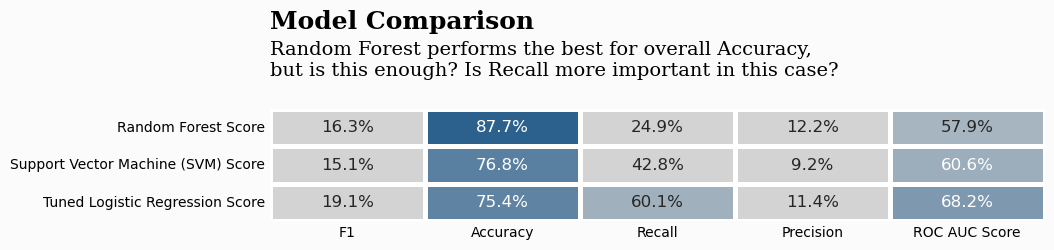

In [42]:
df_models = round(pd.concat([rf_df,svm_df,lr_df], axis=1),3)
import matplotlib
colors = ["lightgray","lightgray","#0f4c81"]
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

background_color = "#fbfbfb"

fig = plt.figure(figsize=(10,8)) # create figure
gs = fig.add_gridspec(4, 2)
gs.update(wspace=0.1, hspace=0.5)
ax0 = fig.add_subplot(gs[0, :])

sns.heatmap(df_models.T, cmap=colormap,annot=True,fmt=".1%",vmin=0,vmax=0.95, linewidths=2.5,cbar=False,ax=ax0,annot_kws={"fontsize":12})
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color) 

ax0.text(0,-2.15,'Model Comparison',fontsize=18,fontweight='bold',fontfamily='serif')
ax0.text(0,-0.9,'Random Forest performs the best for overall Accuracy,\nbut is this enough? Is Recall more important in this case?',fontsize=14,fontfamily='serif')
ax0.tick_params(axis=u'both', which=u'both',length=0)


plt.show()

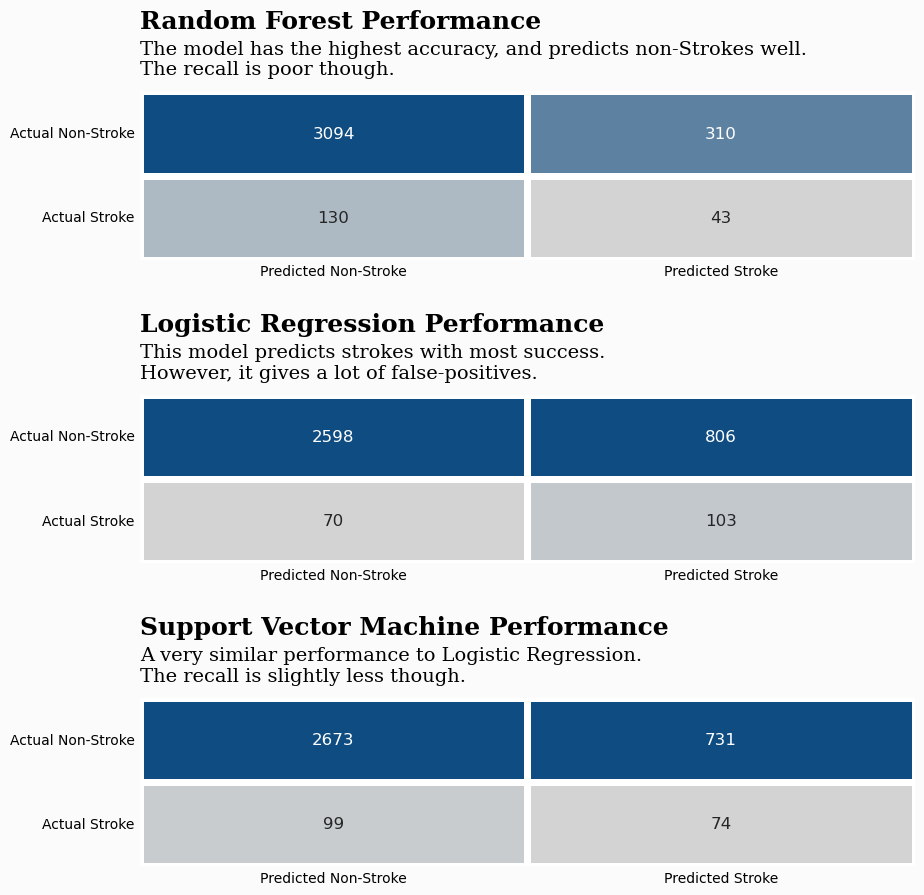

In [43]:
# Plotting our results

colors = ["lightgray","#0f4c81","#0f4c81","#0f4c81","#0f4c81","#0f4c81","#0f4c81","#0f4c81"]
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)


background_color = "#fbfbfb"

fig = plt.figure(figsize=(10,14)) # create figure
gs = fig.add_gridspec(4, 2)
gs.update(wspace=0.1, hspace=0.8)
ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[1, :])
ax2 = fig.add_subplot(gs[2, :])
ax0.set_facecolor(background_color) # axes background color

# Overall
sns.heatmap(rf_cm, cmap=colormap,annot=True,fmt="d", linewidths=5,cbar=False,ax=ax0,
            yticklabels=['Actual Non-Stroke','Actual Stroke'],xticklabels=['Predicted Non-Stroke','Predicted Stroke'],annot_kws={"fontsize":12})

sns.heatmap(logreg_cm, cmap=colormap,annot=True,fmt="d", linewidths=5,cbar=False,ax=ax1,
            yticklabels=['Actual Non-Stroke','Actual Stroke'],xticklabels=['Predicted Non-Stroke','Predicted Stroke'],annot_kws={"fontsize":12})

sns.heatmap(svm_cm, cmap=colormap,annot=True,fmt="d", linewidths=5,cbar=False,ax=ax2,
            yticklabels=['Actual Non-Stroke','Actual Stroke'],xticklabels=['Predicted Non-Stroke','Predicted Stroke'],annot_kws={"fontsize":12})

ax0.tick_params(axis=u'both', which=u'both',length=0)
background_color = "#fbfbfb"
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color) 
ax1.tick_params(axis=u'both', which=u'both',length=0)
ax1.set_facecolor(background_color) 
ax2.tick_params(axis=u'both', which=u'both',length=0)
ax2.set_facecolor(background_color)

ax0.text(0,-0.75,'Random Forest Performance',fontsize=18,fontweight='bold',fontfamily='serif')
ax0.text(0,-0.2,'The model has the highest accuracy, and predicts non-Strokes well.\nThe recall is poor though.',fontsize=14,fontfamily='serif')

ax1.text(0,-0.75,'Logistic Regression Performance',fontsize=18,fontweight='bold',fontfamily='serif')
ax1.text(0,-0.2,'This model predicts strokes with most success.\nHowever, it gives a lot of false-positives.',fontsize=14,fontfamily='serif')

ax2.text(0,-0.75,'Support Vector Machine Performance',fontsize=18,fontweight='bold',fontfamily='serif')
ax2.text(0,-0.2,'A very similar performance to Logistic Regression.\nThe recall is slightly less though.',fontsize=14,fontfamily='serif')

plt.show()

Recall, also known as the true positive rate (TPR), is the percentage of data samples that a machine learning model correctly identifies as belonging to a class of interest—the “positive class”—out of the total samples for that class.

# 8. Decision
Logistric Regression is selected as the best model for this case because in the health care setting, itwould be more important that an actual stroke is predictied, therefore recall is important.

Though Random Forest had the highest accuracy, the tuned LR provide the best recall and f1 score.

## 9. Diving into how the models are predicting results
Here, we do more analysis ot learn how Random Forest makes its predictions. Knowing that the accuracy is high, but no reliable in this case for imbalanced data.

In [44]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'Feature':df.columns,'Importance':m.feature_importances_}).sort_values('Importance', ascending=False)

fi = rf_feat_importance(rf_pipeline['RF'], X)
fi[:10].style.background_gradient(cmap=colormap)

,Feature,Importance
1,age,0.403754
6,bmi,0.219128
5,avg_glucose_level,0.200847
4,work_type,0.078897
0,gender,0.064030
2,hypertension,0.021158
3,heart_disease,0.012186


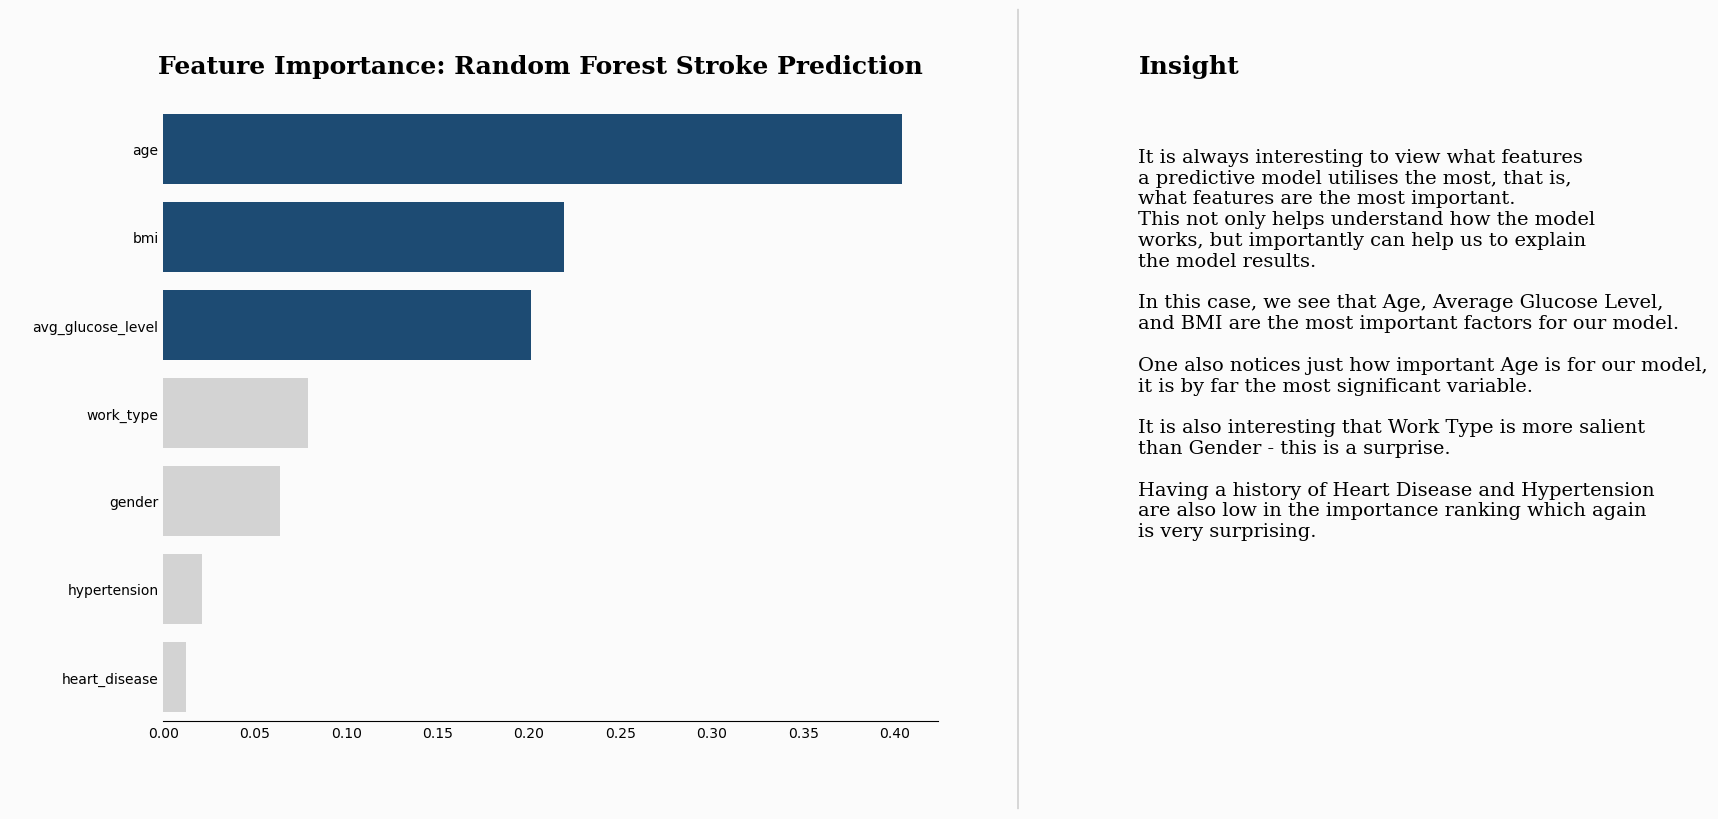

In [45]:
#plotting the top 3 features: age, bmi, glucose
ackground_color = "#fbfbfb"

fig, ax = plt.subplots(1,1, figsize=(10, 8),facecolor=background_color)

color_map = ['lightgray' for _ in range(10)]
color_map[0] = color_map[1] = color_map[2] =  '#0f4c81' # color highlight

sns.barplot(data=fi,x='Importance',y='Feature',ax=ax,palette=color_map)
ax.set_facecolor(background_color) 
for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)
    
fig.text(0.12,0.92,"Feature Importance: Random Forest Stroke Prediction", fontsize=18, fontweight='bold', fontfamily='serif')

    
plt.xlabel(" ", fontsize=12, fontweight='light', fontfamily='serif',loc='left',y=-1.5)
plt.ylabel(" ", fontsize=12, fontweight='light', fontfamily='serif')


fig.text(1.1, 0.92, 'Insight', fontsize=18, fontweight='bold', fontfamily='serif')

fig.text(1.1, 0.315, '''
It is always interesting to view what features
a predictive model utilises the most, that is, 
what features are the most important. 
This not only helps understand how the model
works, but importantly can help us to explain
the model results.

In this case, we see that Age, Average Glucose Level,
and BMI are the most important factors for our model.

One also notices just how important Age is for our model,
it is by far the most significant variable.

It is also interesting that Work Type is more salient
than Gender - this is a surprise.

Having a history of Heart Disease and Hypertension
are also low in the importance ranking which again
is very surprising.
'''
         , fontsize=14, fontweight='light', fontfamily='serif')

ax.tick_params(axis=u'both', which=u'both',length=0)

import matplotlib.lines as lines
l1 = lines.Line2D([0.98, 0.98], [0, 1], transform=fig.transFigure, figure=fig,color='black',lw=0.2)
fig.lines.extend([l1])


plt.show()

## Using LIME for model interpretation
It is useful to unpack and focus on a model to understand how it works.

Lime stands for Local Interpretable Model-agnostic Explanation.

In [46]:
import lime
import lime.lime_tabular

#Lime has one explainer for all the models
explainer = lime.lime_tabular.LimeTabularExplainer(X.values, feature_names= X.columns.values.tolist(),
                                                  class_names=['stroke'], verbose= True, mode='classification')


In [47]:
#choose the j-th instance and use it to predict the results for that selection 
j = 1
exp = explainer.explain_instance(X.values[j], logreg_pipeline.predict_proba, num_features=5)

Intercept 0.09413583756056412
Prediction_local [0.30534095]
Right: 0.4762878981774099


In [48]:
#show predictions
exp.show_in_notebook(show_table=True)

## ELI5 for feature explanation
With this, we see the coefficient for each variable, meaning What our logistic model puts most value in.

In [49]:
import eli5

columns_ = ['gender', 'age', 'hypertension', 'heart_disease', 'work_type',
       'avg_glucose_level', 'bmi']

eli5.show_weights(logreg_pipeline.named_steps["LR"], feature_names=columns_)

Weight?,Feature
+1.965,age
+0.224,bmi
+0.175,avg_glucose_level
-0.273,heart_disease
-0.374,work_type
-0.376,hypertension
-0.392,<BIAS>
-0.773,gender


## 10. Conclusion
We started by exploring features that have some relationship and find our which attributes has the biggest affect on the outcome by using extensive visualisation. 

Then we tried multiple models: Random Forest, SVM, Logistic Regression

Hyperparameter tuning was then applied to our models to see if the results improve.

While RF had the highest accuracy, because our data was imbalance, accuracy is not a good metric to measure the performance of the model. The Tuned LR model provided the best recall and f1score. 

To try to understand how RF was using our data to get the highest accuracy score, we looked at feature importance. SHAP was used to understand how models make predictions, and also where they might be going wrong. 

Finally, we used LIME and ELI5 on our best model -- tuned LR to show how the features interact with each other to produce the prediction results in the model.

This notebook was created with reference to Joshua Swords and I think he did very well in teaching us machine learning and how to dive deeper with visualisations and packages to help us understand our model more. 

I have learned a lot from his notebook in this project especially making plots with grids. It has made plotting much neater and organised. I am inspired to use that knowledge to work on my future projects. 

**Thank you Joshua!**